In [6]:
## Machine-assisted virology identifies candidate human proteins degraded by dengue viruses during infection

## This notebook has the code to generate Figure 1C (machine learning predictions) and Table S1.
## Note that slightly different predictions will be found in each run,
## because the model training on the data is in part stochastic.

# this cell: preliminaries
import re
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pickle
from sklearn.svm import SVC
import gzip


if torch.cuda.is_available():
    device = torch.device("cuda")
    cudaname = torch.cuda.get_device_name()
    print(f"Using {device} device {cudaname}.")
else:
    device = torch.device("cpu")
    print("Using CPU device.")
    
dire = './' # <-- SET YOUR WORKING DIRECTORY
FREEZE = True # as in the paper, otherwise its an ad lib excursion
DoNewRuns = False # do full retraining on data (versus using stored model files, see use below)

# OK to ignore any warnings about Axes3D that immediately follow

Using CPU device.


In [7]:
# define functions and load data for one or more runs

# chemical properties of amino acids (for reference only, not used in this notebook):
aa_props = {
    'I': (0.0, 0.0,  4.5, 0.0),
    'V': (1.0, 0.0,  4.2, 0.0),
    'L': (0.0, 0.0,  3.8, 0.0),
    'F': (0.0, 0.0,  2.8, 1.0),
    'C': (1.0, 0.0,  2.5, 0.0),
    'M': (0.0, 0.0,  1.9, 0.0),
    'A': (2.0, 0.0,  1.8, 0.0),
    'G': (2.0, 0.0, -0.4, 0.0),
    'T': (1.0, -1.0, -0.7, 0.0),
    'W': (0.0, 1.0, -0.9, 1.0),
    'S': (2.0, -1.0, -0.8, 0.0),
    'Y': (0.0, -1.0, -1.3, 1.0),
    'P': (1.0, 0.0, -1.6, 0.0),
    'H': (0.0, 2.0, -3.2, 1.0),
    'E': (0.0, -2.0, -3.5, 0.0),
    'Q': (0.0, 1.0, -3.5, 0.0),
    'D': (1.0, -2.0, -3.5, 0.0),
    'N': (1.0, 1.0, -3.5, 0.0),
    'K': (0.0, 2.0, -3.9, 0.0),
    'R': (0.0, 2.0, -4.5, 0.0),
}

def increment_path(some_xxx_path):
    # utility to prevent overwriting a previously pickled result
    regex_pattern = re.escape(some_xxx_path).replace("xxx", r"(\d+)")
    glob_pattern = some_xxx_path.replace("xxx", "*")
    existing_files = glob.glob(glob_pattern)
    numbers = []
    for f in existing_files:
        m = re.search(regex_pattern, f)
        if m: numbers.append(int(m.group(1)))
    next_number = max(numbers, default=0) + 1
    new_file = some_xxx_path.replace("xxx", str(next_number))
    print(f'creating {new_file}')
    return new_file

def load_file(file_path, first_data_col=1):
    data = []
    labels = []
    with open(file_path, 'r') as file:
        header = next(file)  # Skip the header line
        seen = {}
        dupes = 0
        for line_num, line in enumerate(file, start=2):  # Line numbers start from 2 (after header)
            try:
                values = line.strip().split("\t")
                first_col = values[0].strip()  # The first column (string of length 8)
                if first_col in seen :
                    dupes += 1
                else :
                    seen[first_col] = 1
                    rest_cols = np.array(values[first_data_col:], dtype=float)  # Remaining columns
                    if len(first_col) != 8:
                        raise ValueError(f"Invalid length of first column '{first_col}', expected length 8.")
                    indices = [ord(char.upper()) - ord('A') for char in first_col]
                    if not all(0 <= idx < 26 for idx in indices):
                        raise ValueError(f"Invalid character in first column: {first_col}")
                    one_hot = np.eye(26)[indices].flatten()  # One-hot encode and flatten
                    # Combine the one-hot vector with the remaining columns
                    if FREEZE :
                        row = np.concatenate([one_hot, rest_cols])
                    else :
                        row = one_hot # excursion: sequence only
                    data.append(row)
                    labels.append(" ".join(values[:first_data_col]))
            except ValueError as e:
                print(f"Skipping invalid line {line_num} in file {file_path}: {line.strip()} ({e})")
    if dupes > 0 : print(f'{file_path} duplicate rows found: {dupes}')
    data_array = np.array(data)
    return data_array, labels

def load_only_class_0(file_path) :
    data_class_0 = load_file(file_class_0)
    DoStops = False
    if DoStops :
        stops = [ 212,  299,  398,  835, 1028, 1120, 1882, 1883, 1906, 2486, 2550, 2566, 2813, 3177, 3342]
        data_class_0 = np.delete(data_class_0, stops, axis=0)    
    return data_class_0

def load_only_class_1(file_path) :
    data_class_1 = load_file(file_class_1)
    return data_class_1

def resample_data(X_0, X_1) :
    n0 = X_0.shape[0]
    n1 = X_1.shape[0]
    indices_0 = np.random.choice(n0, size=n0, replace=True)
    indices_1 = np.random.choice(n1, size=n1, replace=True)
    resampled_0 = X_0[indices_0]
    resampled_1 = X_1[indices_1]
    X_train = np.vstack((resampled_0, resampled_1))
    y_train = np.hstack((np.zeros(len(resampled_0)), np.ones(len(resampled_1))))
    return X_train, y_train
    
def split_data(X_0, X_1, ftest0, ftrain0, ftest1, ftrain1):
    data_class_0 = X_0.copy()
    data_class_1 = X_1.copy()

    DoStops = False
    if DoStops : # these neg examples are likely actually positive
        stops = [ 216, 1899, 2308, 2686, 2829, 3464, 6075, 6352, 6417, 7143, 7628, 8022, 8200]
        data_class_0 = np.delete(data_class_0, stops, axis=0)
        
    num_train_0 = int(ftrain0 * len(data_class_0))
    num_train_1 = int(ftrain1 * len(data_class_1))
    num_test_0 = int(ftest0 * len(data_class_0))
    num_test_1 = int(ftest1 * len(data_class_1))

    # Shuffle and split data for class 0
    indices_class_0 = np.random.permutation(len(data_class_0))
    test_indices_0 = indices_class_0[:num_test_0]
    train_indices_0 = indices_class_0[num_test_0:num_test_0 + num_train_0]
    test_class_0 = data_class_0[test_indices_0]
    train_class_0 = data_class_0[train_indices_0]

    # Shuffle and split data for class 1
    indices_class_1 = np.random.permutation(len(data_class_1))
    test_indices_1 = indices_class_1[:num_test_1]
    train_indices_1 = indices_class_1[num_test_1:num_test_1 + num_train_1]
    test_class_1 = data_class_1[test_indices_1]
    train_class_1 = data_class_1[train_indices_1]

    # Combine data and create labels
    X_train = np.vstack((train_class_0, train_class_1))
    y_train = np.hstack((np.zeros(len(train_class_0)), np.ones(len(train_class_1))))
    X_test = np.vstack((test_class_0, test_class_1))
    y_test = np.hstack((np.zeros(len(test_class_0)), np.ones(len(test_class_1))))

    return X_train, y_train, X_test, y_test, num_train_0, num_train_1, num_test_0, num_test_1

def show_results(ytest,ypred) :
    if isinstance(ytest, torch.Tensor) :
        tn = torch.sum((ytest == 0) & (ypred == 0)).item()
        fn = torch.sum((ytest == 1) & (ypred == 0)).item()
        tp = torch.sum((ytest == 1) & (ypred == 1)).item()
        fp = torch.sum((ytest == 0) & (ypred == 1)).item()
    else :
        tn = np.sum((ytest == 0) & (ypred == 0))
        fn = np.sum((ytest == 1) & (ypred == 0))
        tp = np.sum((ytest == 1) & (ypred == 1))
        fp = np.sum((ytest == 0) & (ypred == 1))         
    print(f"TP={tp:4d}  FP={fp:4d}")
    print(f"FN={fn:4d}  TN={tn:4d}")
    sens = tp/(tp+fn+1.e-30)
    prec = tp/(tp+fp+1.e-30)
    print(f"sensitivity={sens:.3f} precision={prec:.3f}")

# load all the training, testing, and allpredict data
mydir = dire # set above, can change here
if FREEZE :
    file_class_0 = mydir + "training_examples.negatives_nopct.tsv"
    file_class_1 = mydir + "training_examples.positives_nopct.tsv"
    file_allpredict = mydir + "sites_to_test_ER_and_ER_membrane_with_encoding_nopct.tsv"
else :
    # can try different files here if you want
    file_class_0 = mydir + "training_examples.negatives_nopct.tsv"
    file_class_1 = mydir + "training_examples.positives_nopct.tsv"
    file_allpredict = mydir + "sites_to_test_ER_and_ER_membrane_with_encoding_nopct.tsv"

X_class0a, labels_class0 = load_file(file_class_0)
X_class1a, labels_class1 = load_file(file_class_1)
X_allpredicta, labels_allpredict = load_file(file_allpredict,first_data_col=2)
X_trainpredicta = np.vstack((X_class0a, X_class1a)) # will run training data through final models as check
labels_trainpredict = labels_class0 + labels_class1
# prevent inadvertent modification of the original data
X_class0a.setflags(write=False)
X_class1a.setflags(write=False)
X_allpredicta.setflags(write=False)
X_trainpredicta.setflags(write=False)

X_class0 = torch.tensor(X_class0a, dtype=torch.float64, device=device, requires_grad=False)
X_class1 = torch.tensor(X_class1a, dtype=torch.float64, device=device, requires_grad=False)
X_allpredict = torch.tensor(X_allpredicta, dtype=torch.float64, device=device, requires_grad=False)
X_trainpredict = torch.tensor(X_trainpredicta, dtype=torch.float64, device=device, requires_grad=False)

print(f"Xclass0_shape: {X_class0.shape}")
print(f"Xclass1_shape: {X_class1.shape}")
print(f"X_allpredict shape: {X_allpredict.shape}")
print(f"X_trainpredict shape: {X_trainpredict.shape}")

# it's normal for ~2418 duplicate rows to be found (out of ~78770)

./sites_to_test_ER_and_ER_membrane_with_encoding_nopct.tsv duplicate rows found: 2418
Xclass0_shape: torch.Size([8286, 240])
Xclass1_shape: torch.Size([259, 240])
X_allpredict shape: torch.Size([78770, 240])
X_trainpredict shape: torch.Size([8545, 240])


In [4]:
# This cell: Define the neural network architecture and related functions

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size, dtype=torch.float64)  # Input to same-width hidden layer
        self.fc2 = nn.Linear(input_size, input_size, dtype=torch.float64)  # Input to same-width hidden layer
        #self.fc3 = nn.Linear(input_size, input_size, dtype=torch.float64)  # Input to same-width hidden layer
        self.fc4 = nn.Linear(input_size, 2, dtype=torch.float64)                    # Size 6 to output size 2

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.sigmoid(x) # also tried torch.softmax(x, dim=1) not as good
    
    def forward_logit(self, x): # same as forward except no softmax, used to find outliers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        return(self.fc4(x))

def weighted_bce_loss(outputs, targets, pos_weight): # not used (weighting didn't improve anything)
    bce_loss = nn.BCELoss(reduction='none')(outputs, targets)
    weights = targets * pos_weight + (1 - targets)  # Apply weights to class 1 and class 0
    return (weights * bce_loss).mean()

# Training function
def train_nn(model, X_train, y_train, X_test, y_test, num_epochs=1000, print_interval=100, lr=0.01, verbose=False):
    optimizer = Adam(model.parameters(), lr=lr)
    myweight = 1.
    loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss for probabilistic output
    y_train_one_hot = F.one_hot(y_train, num_classes=2).to(dtype=torch.float64)  # Convert y_train to one-hot encoding
    y_test_one_hot = F.one_hot(y_test, num_classes=2).to(dtype=torch.float64)    # Convert y_test to one-hot encoding

    for epoch in range(num_epochs):
        # Forward pass on training data
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = loss_fn(outputs, y_train_one_hot)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        # Periodically print loss and test accuracy
        if verbose and epoch % print_interval == 0:
            # Evaluate on test data
            model.eval()
            with torch.no_grad():
                test_outputs = model(X_test)
                test_predictions = torch.argmax(test_outputs, dim=1)
                test_accuracy = (test_predictions == y_test).float().mean().item()
                print(f"Epoch {epoch:4d} | Loss: {loss.item():.4f} | Test Accuracy: {test_accuracy:.4f}")

def do_a_training_run(fsplits=None, Production=True, Verbose=True, epochs=1000) :
    # keep all the data in globals
    global X_traina, X_train, y_traina, y_train, X_testa, X_test, y_testa, y_test
    if Production :
        X_traina, y_traina = resample_data(X_class0a, X_class1a)
        X_train = torch.tensor(X_traina, dtype=torch.float64, device=device)
        y_train = torch.tensor(y_traina, dtype=torch.int64, device=device)
        X_test = X_train[:10] # dummy
        y_test = y_train[:10] # dummy
    else :
        ftest0, ftrain0, ftest1, ftrain1 = fsplits
        X_traina, y_traina, X_testa, y_testa, ntrain0, ntrain1, ntest0, ntest1 = (
            split_data(X_class0a, X_class1a, ftest0, ftrain0, ftest1, ftrain1))
        X_train = torch.tensor(X_traina, dtype=torch.float64, device=device)
        y_train = torch.tensor(y_traina, dtype=torch.int64, device=device)
        X_test = torch.tensor(X_testa, dtype=torch.float64, device=device)
        y_test = torch.tensor(y_testa, dtype=torch.int64, device=device)
        if Verbose: print(f"ntrain0 {ntrain0}, ntrain1 {ntrain1}, ntest0 {ntest0}, ntest1 {ntest1}")

    if Verbose :
        print(f"X_train shape: {X_train.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"X_test shape: {X_test.shape}")
        print(f"y_test shape: {y_test.shape}")
    
    input_size = X_train.size(1)  # Number of features
    model = SimpleNN(input_size).to(X_train.device)
    train_nn(model, X_train, y_train, X_test, y_test, num_epochs=epochs, print_interval=100, lr=0.01, verbose=Verbose)
    test_outputs = model(X_test)
    y_pred_binary = torch.argmax(test_outputs, dim=1) # pick the column with greater probability
    if Verbose :
        show_results(y_test,y_pred_binary)
    return model

In [8]:
%%time
# This cell: do NN training and evaluate model on test data

DoOnlyOneNow = False # just one run (sanity check)? or production with many averaged runs

if DoOnlyOneNow :
    fsplits = (0.4,0.6,0.4,0.6) # ftest0, ftrain0, ftest1, ftrain1
    model = do_a_training_run(fsplits=fsplits, Production=False, Verbose=True, epochs=1000)
    y_pred = model.forward_logit(X_test)
    logit = y_pred.detach().cpu().numpy()[:,1]
    ytesta_nn = y_testa.copy() # for later use in ROC curve
    logit_nn = logit.copy()

elif DoNewRuns : # do Niter separate training runs, allpredict each, record mean and s.d. results in a dict
    Niter = 100
    Verbose = False
    nn_results_dict = {}
    nn_musig_dict = {}
    nn_trainresults_dict = {}
    nn_trainmusig_dict = {}

    for it in range(Niter) :
        if it % 10 == 0 : print(f'{it+1}', end='')
        else : print('.',end='')
        model = do_a_training_run(fsplits=None, Production=True, Verbose=Verbose, epochs=1000)
        logits = model.forward_logit(X_allpredict).detach().cpu().numpy()[:,0]
        trainlogits = model.forward_logit(X_trainpredict).detach().cpu().numpy()[:,0]
        if Verbose:
            print(f"logits shape: {logits.shape}")
            print(f"trainlogits shape: {trainlogits.shape}")
        for key, value in zip(labels_allpredict, logits) :
            nn_results_dict.setdefault(key, []).append(value)
        for key, value in zip(labels_trainpredict, trainlogits) :
            nn_trainresults_dict.setdefault(key, []).append(value)
    print('\n')
    nn_musig_dict = {key: (np.mean(values), np.std(values, ddof=0)/np.sqrt(len(values)+1.e-30))
            for key, values in nn_results_dict.items()}
    nn_trainmusig_dict = {key: (np.mean(values), np.std(values, ddof=0)/np.sqrt(len(values)+1.e-30))
            for key, values in nn_trainresults_dict.items()}

    nnoutfile = increment_path(dire + f'nn_results_{Niter}iter_xxx.pkl') # get a unique filename
    with open(nnoutfile, 'wb') as f:
        pickle.dump((nn_results_dict,nn_musig_dict,nn_trainresults_dict,nn_trainmusig_dict), f)
else :
    print('Skipping NN runs, assuming will load a stored model below.')
print('done.')

# on a consumer-grade NVIDIA GeForce RTX 3090 takes ~10 sec per iteration

Skipping NN runs, assuming will load a stored model below.
done.
CPU times: user 297 μs, sys: 271 μs, total: 568 μs
Wall time: 335 μs


In [9]:
# This cell: Support Vector Machine (SVM) model functions

def logit_list(prob_pairs):
    return [np.log(min(a, b) / (1 - min(a, b))) * (1 if min(a, b) == a else -1)
            for a, b in prob_pairs]

def do_a_SVM_run(fsplits=None, Production=True, Verbose=True) :
    if Production :
        X_traina, y_traina = resample_data(X_class0a, X_class1a)
    else :
        ftest0, ftrain0, ftest1, ftrain1 = fsplits
        X_traina, y_traina, X_testa, y_testa, ntrain0, ntrain1, ntest0, ntest1 = (
            split_data(X_class0a, X_class1a, ftest0, ftrain0, ftest1, ftrain1))
        if Verbose: print(f"ntrain0 {ntrain0}, ntrain1 {ntrain1}, ntest0 {ntest0}, ntest1 {ntest1}")
   # Convert labels to {-1, 1} for SVM
    y_train_svm = 2 * y_traina - 1
    if Verbose: print(y_traina.shape)
    svc_model = SVC( kernel='rbf', C=5., probability=True)
    svc_model.fit(X_traina, y_train_svm)
    if Production :
        logits = np.array(logit_list(svc_model.predict_proba(X_allpredicta)))
        trainlogits = np.array(logit_list(svc_model.predict_proba(X_trainpredicta)))
        if Verbose:
            print(f"logits shape: {logits.shape}")
            print(f"trainlogits shape: {trainlogits.shape}")
        return logits,trainlogits
    else :
        logits = np.array(logit_list(svc_model.predict_proba(X_testa)))
        return y_testa, logits
      

In [10]:
%%time
# production run with SVC
DoOnlyOneNow = False  #just one run (sanity check)? or production with many averaged runs

if DoOnlyOneNow :
    fsplits = (0.4,0.6,0.4,0.6) # ftest0, ftrain0, ftest1, ftrain1
    y_testa,logits = do_a_SVM_run(fsplits=fsplits,Production=False,Verbose=True)
    y_pred = (logits < 2.0)
    show_results(y_testa,y_pred)
elif DoNewRuns : # do Niter separate training runs, allpredict each, record mean and s.d. results in a dict
    Niter = 100
    Verbose = False
    svm_results_dict = {}
    svm_musig_dict = {}
    svm_trainresults_dict = {}
    svm_traommusig_dict = {}

    printevery = 10**np.floor(np.log10(Niter-1))
    for it in range(Niter) :
        if it % 10 == 0 : print(f'{it+1}', end='')
        else : print('.', end='')
        logits, trainlogits = do_a_SVM_run(Verbose=Verbose)
        if Verbose: print(f"logits shape: {logits.shape}")
        for key, value in zip(labels_allpredict, logits) :
            svm_results_dict.setdefault(key, []).append(value)
        for key, value in zip(labels_trainpredict, trainlogits) :
            svm_trainresults_dict.setdefault(key, []).append(value)
    print('\n')
    svm_musig_dict = {key: (np.mean(values), np.std(values, ddof=0)/np.sqrt(len(values)+1.e-30))
            for key, values in svm_results_dict.items()}
    svm_trainmusig_dict = {key: (np.mean(values), np.std(values, ddof=0)/np.sqrt(len(values)+1.e-30))
            for key, values in svm_trainresults_dict.items()}

    svoutfile = increment_path(dire + f'svm_results_{Niter}iter_xxx.pkl')
    with open(svoutfile, 'wb') as f:
        pickle.dump((svm_results_dict,svm_musig_dict,svm_trainresults_dict,svm_trainmusig_dict), f)
else :
    print('Skipping SVM runs, assuming will load a stored model below.')
print('done.')

# typically a few seconds per run, message at 1, 11, 101 (etc.)

Skipping SVM runs, assuming will load a stored model below.
done.
CPU times: user 294 μs, sys: 92 μs, total: 386 μs
Wall time: 352 μs


In [14]:
# This cell: load model results for making plot and table

if DoNewRuns: # use pickle files just computed? or older ones
    nninfile = nnoutfile # as set above
    svinfile = svoutfile # as set above
else:
    nninfile = dire + 'nn_results_100iter_1.pkl.gz'  # or your other saved file
    svinfile = dire + 'svm_results_100iter_1.pkl.gz' # or your other saved file

with gzip.open(nninfile, 'rb') as f:
    (nn_results_dict,nn_musig_dict,nn_trainresults_dict,nn_trainmusig_dict) = pickle.load(f)
print(f'loaded nn_results_dict, nn_musig_dict (and train counterparts) from {nninfile}')
with gzip.open(svinfile, 'rb') as f:
    (svm_results_dict,svm_musig_dict,svm_trainresults_dict,svm_trainmusig_dict) = pickle.load(f)
print(f'loaded svm_results_dict, svm_musig_dict (and trains) from {svinfile}')    


loaded nn_results_dict, nn_musig_dict (and train counterparts) from ./nn_results_100iter_1.pkl.gz
loaded svm_results_dict, svm_musig_dict (and trains) from ./svm_results_100iter_1.pkl.gz


In [15]:
# Create master list

# lists of experimental results
# (manually curated, so these lists may not be final lists in the paper)

testedpos = ["RGRRTGSP AVPR2","KKRRGSGV DISP3","KRKKGSTM CYBA","RTKRGPGP PDE3B","KKRRSYGN SELENOK", "SRTRGAQL FAM134B",
            "RGHRDTSM SEC61A2","RRRRRGCA ATP10A","SGKKSSSA JKAMP","KKRRYLPY FADS3","GGRRSQWV DGAT2","SRYRGSYW STING1"]

testedneg = ["QKRRGGST SLC39A7","RRKRMSVA RHBDF2","HPKRSVSL BNIP3L","PSRRSVPV PREB", "GGHRGGGG CKAP4",
             "PGKRSEGG IKBIP","RRRRASSV EI24", "RPRRPCIC BRSK2","SRRNGWSW ZDHHC1", "NNRQSQVL ATP8B2"]

common_keys = sorted(set(svm_musig_dict.keys()) & set(nn_musig_dict.keys()))
all_svm_means = np.array([svm_musig_dict[k][0] for k in common_keys])
all_svm_ranks = np.argsort(np.argsort(all_svm_means)) + 1
all_nn_means = np.array([nn_musig_dict[k][0] for k in common_keys])
all_nn_ranks = np.argsort(np.argsort(all_nn_means)) + 1
rank_dict = dict(zip(common_keys, zip(all_svm_ranks, all_nn_ranks)))
upper_lim = 70

# print the master list and keep data table for plotting (next cell)
dists =  np.minimum(all_nn_ranks , all_svm_ranks)
indx = np.argsort(dists)[:upper_lim]
table_rows = []

print(f"    gene       cut     best-rank  NN logit/rank SVM logit/rank  expt" )
for j,i in enumerate(indx) :
    lab = common_keys[i].split()
    if common_keys[i] in testedpos :
        expt = "POS"
    elif common_keys[i] in testedneg :
        expt = "neg"
    else :
        expt = '.'
    table_row = (f"{j+1:3d} {lab[1]:10} {lab[0]:10} {dists[i]:6.0f} {all_nn_means[i]:6.1f}" +
              f" {all_nn_ranks[i]:3.0f}      {all_svm_means[i]:6.1f} {all_svm_ranks[i]:3.0f}     {expt}")
    table_rows.append(table_row)
table = "\n".join(table_rows)
print(table)
# table can be saved or injested in Pandas for other uses (e.g., plotting in next cell)


    gene       cut     best-rank  NN logit/rank SVM logit/rank  expt
  1 TENM2      KSRRSSGL        1  -12.2   1       -16.6   1     .
  2 RHBDF1     RRKRESVA        2  -12.0   2        -8.5  22     .
  3 AVPR2      RGRRTGSP        2  -11.2   7       -14.5   2     POS
  4 RHBDF2     RRKRMSVA        3  -11.7   3       -13.9   4     neg
  5 SLC39A7    QKRRGGST        3  -10.7  13       -14.4   3     neg
  6 MCTP1      NRQRDTVV        4  -11.4   4       -10.3  14     .
  7 DISP3      KKRRGSGV        5  -11.4   5       -13.7   5     POS
  8 MOGS       RRRRAVPA        6  -11.3   6        -6.8  34     .
  9 P2RY13     QGRKTTAS        6  -10.5  17       -12.5   6     .
 10 BNIP3L     HPKRSVSL        7  -10.9  11       -12.4   7     neg
 11 PIGB       RKRKSTLY        8  -10.4  18       -12.2   8     .
 12 ATP10A     RRRRRGCA        8  -11.1   8        -5.2  48     POS
 13 CYBA       KRKKGSTM        9  -10.6  14       -12.2   9     POS
 14 PREB       PSRRSVPV        9  -11.1   9       -12.1  10

/var/folders/py/9sy7ycts5xb90mqjpf4529qc0000gp/T/ipykernel_75255/1783576231.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


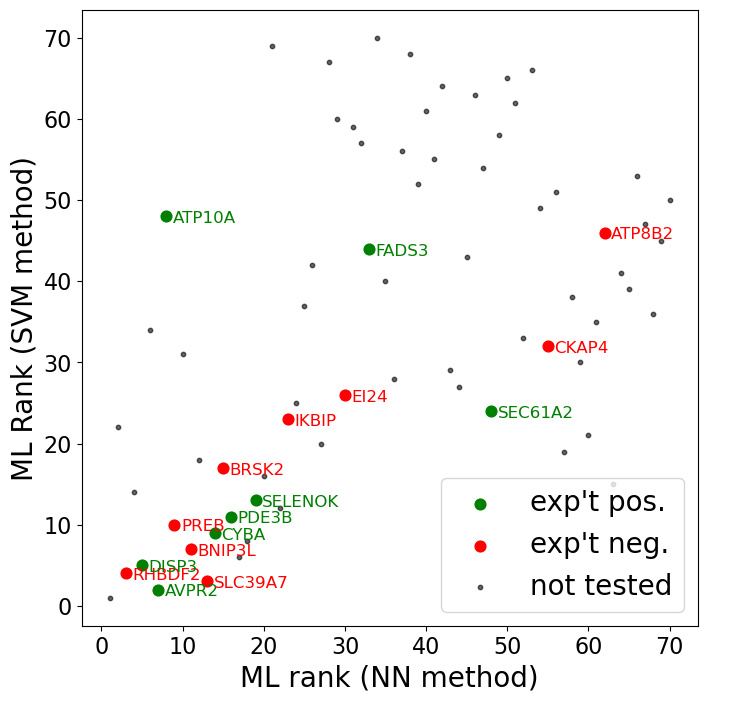

In [23]:
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt

def ingest_table(table_str):
    # Read table, splitting by any whitespace
    df = pd.read_csv(
        StringIO(table_str.strip()),
        delim_whitespace=True,
        header=None,
        names=["Index", "Key", "Sequence", "BestRank", "NNlogit", "NNrank", "SVMlogit", "SVMrank", "Experiment"]
    )
    # Make unique index combining Key and Sequence
    keyseq = df["Sequence"] + " " + df["Key"]
    #df.set_index("KeySeq", inplace=True)
    df.insert(0, 'KeySeq', keyseq)
    return df

def break_ties(primary, secondary):
    ranks = primary.rank(method='min')
    out = ranks.astype(float).copy()
    for tie_rank in sorted(ranks.unique()):
        tie_idx = ranks.index[ranks == tie_rank]
        if len(tie_idx) > 1:
            order = secondary.loc[tie_idx].rank(method='first')
            sorted_idx = order.sort_values(kind='mergesort').index
            m = len(sorted_idx)
            jitter = np.linspace(-0.5, 0.5, m)
            out.loc[sorted_idx] = tie_rank + jitter
    return out.to_numpy()

df_orig = ingest_table(table)
#print(df_orig)
nn_ranks = break_ties(df_orig["NNrank"], df_orig["SVMrank"])
svm_ranks = break_ties(df_orig["SVMrank"], df_orig["NNrank"])

# Masks for groups
mask_c = df_orig["KeySeq"].isin(testedpos).to_numpy()
mask_nc = df_orig["KeySeq"].isin(testedneg).to_numpy()
mask_other = ~(mask_c | mask_nc)

fig = plt.figure(figsize=(8, 8))
plt.scatter(nn_ranks[mask_c],  svm_ranks[mask_c],  s=60, color='green', label=r"exp't pos.")
plt.scatter(nn_ranks[mask_nc], svm_ranks[mask_nc], marker='o', s=60, color='red',   label=r"exp't neg.")
plt.scatter(nn_ranks[mask_other], svm_ranks[mask_other], s=10, color='black', alpha=0.6, label='not tested')

# Annotations
for keyseq, key, x, y in zip(df_orig["KeySeq"], df_orig["Key"], nn_ranks, svm_ranks):
    color = 'green' if keyseq in testedpos else ('red' if keyseq in testedneg else 'none')
    plt.text(x + 0.8, y - 0.25, key, fontsize=12, family='sans-serif', color=color, va='center')
    
plt.xlabel("ML rank (NN method)", fontsize=20)
plt.ylabel("ML Rank (SVM method)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.title("Rank Scatter Plot: NN vs SVM", fontsize=16)
plt.legend(fontsize=20)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [17]:
# some experimentally tested proteins may not be in the figure with any particular run
# here show the SVM and NN ranks of all experimentally tested

for k, keyset in enumerate((testedpos,testedneg)) :
    print(f'model ranks of experimental {"positives" if k==0 else "negatives"}')
    for key in keyset :
        try :
            print(f"{key:20s}: SVM,NN: {rank_dict[key]}")
        except :
            print(f"{key:20s}: SVM,NN: (?, ?)")
    print("")
# ranks are 1..78770 for all tested positions

model ranks of experimental positives
RGRRTGSP AVPR2      : SVM,NN: (np.int64(2), np.int64(7))
KKRRGSGV DISP3      : SVM,NN: (np.int64(5), np.int64(5))
KRKKGSTM CYBA       : SVM,NN: (np.int64(9), np.int64(14))
RTKRGPGP PDE3B      : SVM,NN: (np.int64(11), np.int64(16))
KKRRSYGN SELENOK    : SVM,NN: (np.int64(13), np.int64(19))
SRTRGAQL FAM134B    : SVM,NN: (?, ?)
RGHRDTSM SEC61A2    : SVM,NN: (np.int64(24), np.int64(48))
RRRRRGCA ATP10A     : SVM,NN: (np.int64(48), np.int64(8))
SGKKSSSA JKAMP      : SVM,NN: (np.int64(58), np.int64(55))
KKRRYLPY FADS3      : SVM,NN: (np.int64(44), np.int64(33))
GGRRSQWV DGAT2      : SVM,NN: (np.int64(66), np.int64(108))
SRYRGSYW STING1     : SVM,NN: (np.int64(173), np.int64(624))

model ranks of experimental negatives
QKRRGGST SLC39A7    : SVM,NN: (np.int64(3), np.int64(13))
RRKRMSVA RHBDF2     : SVM,NN: (np.int64(4), np.int64(3))
HPKRSVSL BNIP3L     : SVM,NN: (np.int64(7), np.int64(11))
PSRRSVPV PREB       : SVM,NN: (np.int64(10), np.int64(9))
GGHRGGGG 

In [25]:
##END OF NOTEBOOK